# Credit Card Fraud Detection

This project uses the dataset sourced from Kaggle competition IEEE-CIS Fraud Detection.

Importing data and dependecies

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import seaborn as sns
import warnings
import sklearn as sk 
from sklearn.preprocessing import scale 
import random 
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# Transaction CSVs
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')



In [ ]:
train_transaction.isFraud.unique()
fig = train_transaction.isFraud.value_counts().plot.bar()
fig.set_title('Fraud yes or no')
fig.set_ylabel('Number of Transactions')


array([0, 1], dtype=int64)

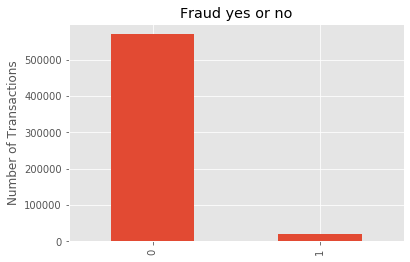

We will combine our data and then check again what the percentage is Fruad in the dataset

In [ ]:

df= pd.merge(train_transaction, train_identity ,how="left",on="TransactionID")

print(  len(df[df["isFraud"] == 1]) / len(df[df["isFraud"] == 0]))



We get that 3.63% of the data contains Fraud. 
We will explore the data further to see what other attributes we can find


# How many columns in our dataset has NA values

In [ ]:
#make it easier to read
df =train_transaction

#check which columns have NA in
vars_with_na = [var for var in df.columns if df[var].isnull().mean() > 0]
print(len(vars_with_na))

414

We see there are 414 columns with NA in them

In [ ]:
#Lets determine the types of data in in these columns
df[vars_with_na].dtypes

baddata = df[vars_with_na].head(10)

#Calaculating the % missing per varaible 
data_na = df[vars_with_na].isnull().mean()
print(baddata )
print(data_na )


Can see V178 to v278 has a high percentage of missing values.. 
This makes the data very varied and will make it tougth to use and will have to consider which imputive method to use
Complete-case analysis (CCA), also called "list-wise deletion" of cases, consists in discarding observations where values in any of the variables are missing.

Complete Case Analysis means literally analysing only those observations for which there is information in all of the variables in the dataset.
You can only use CCA when No more than 5% of the total dataset contains missing data thus we will not be using that here

In [ ]:

# transform the array into a dataframe
data_na = pd.DataFrame(data_na.reset_index())

# add column names to the dataframe
data_na.columns = ['variable', 'na_percentage']


In [ ]:

# order the dataframe according to percentage of na per variable
data_na.sort_values(by='na_percentage', ascending=False, inplace=True)

# capture variables with no or less than 5% NA
vars_cca = [var for var in df.columns if df[var].isnull().mean() < 0.15]

## calculate percentage of observations with complete
# the method dropna(), discards the observations that contain na in any of the rows / columns
len(df[vars_cca].dropna()) / len(df)



0.9803356250462039 at 5%
0.7405696481186711 at 15%  

create the complete case dataset
in other words, remove observations with na in any variable

In [ ]:
# in other words, remove observations with na in any variable
data_cca = df[vars_cca].dropna()
df.shape, data_cca.shape


We lost 434 - 160 = 274 columns of data which is alot..

In [ ]:
# plot the histograms for all numerival variables in the complete dataset to get a quick understanding what the data looks like
data_cca.hist(bins=50, density=True, figsize=(25, 25))
plt.show()

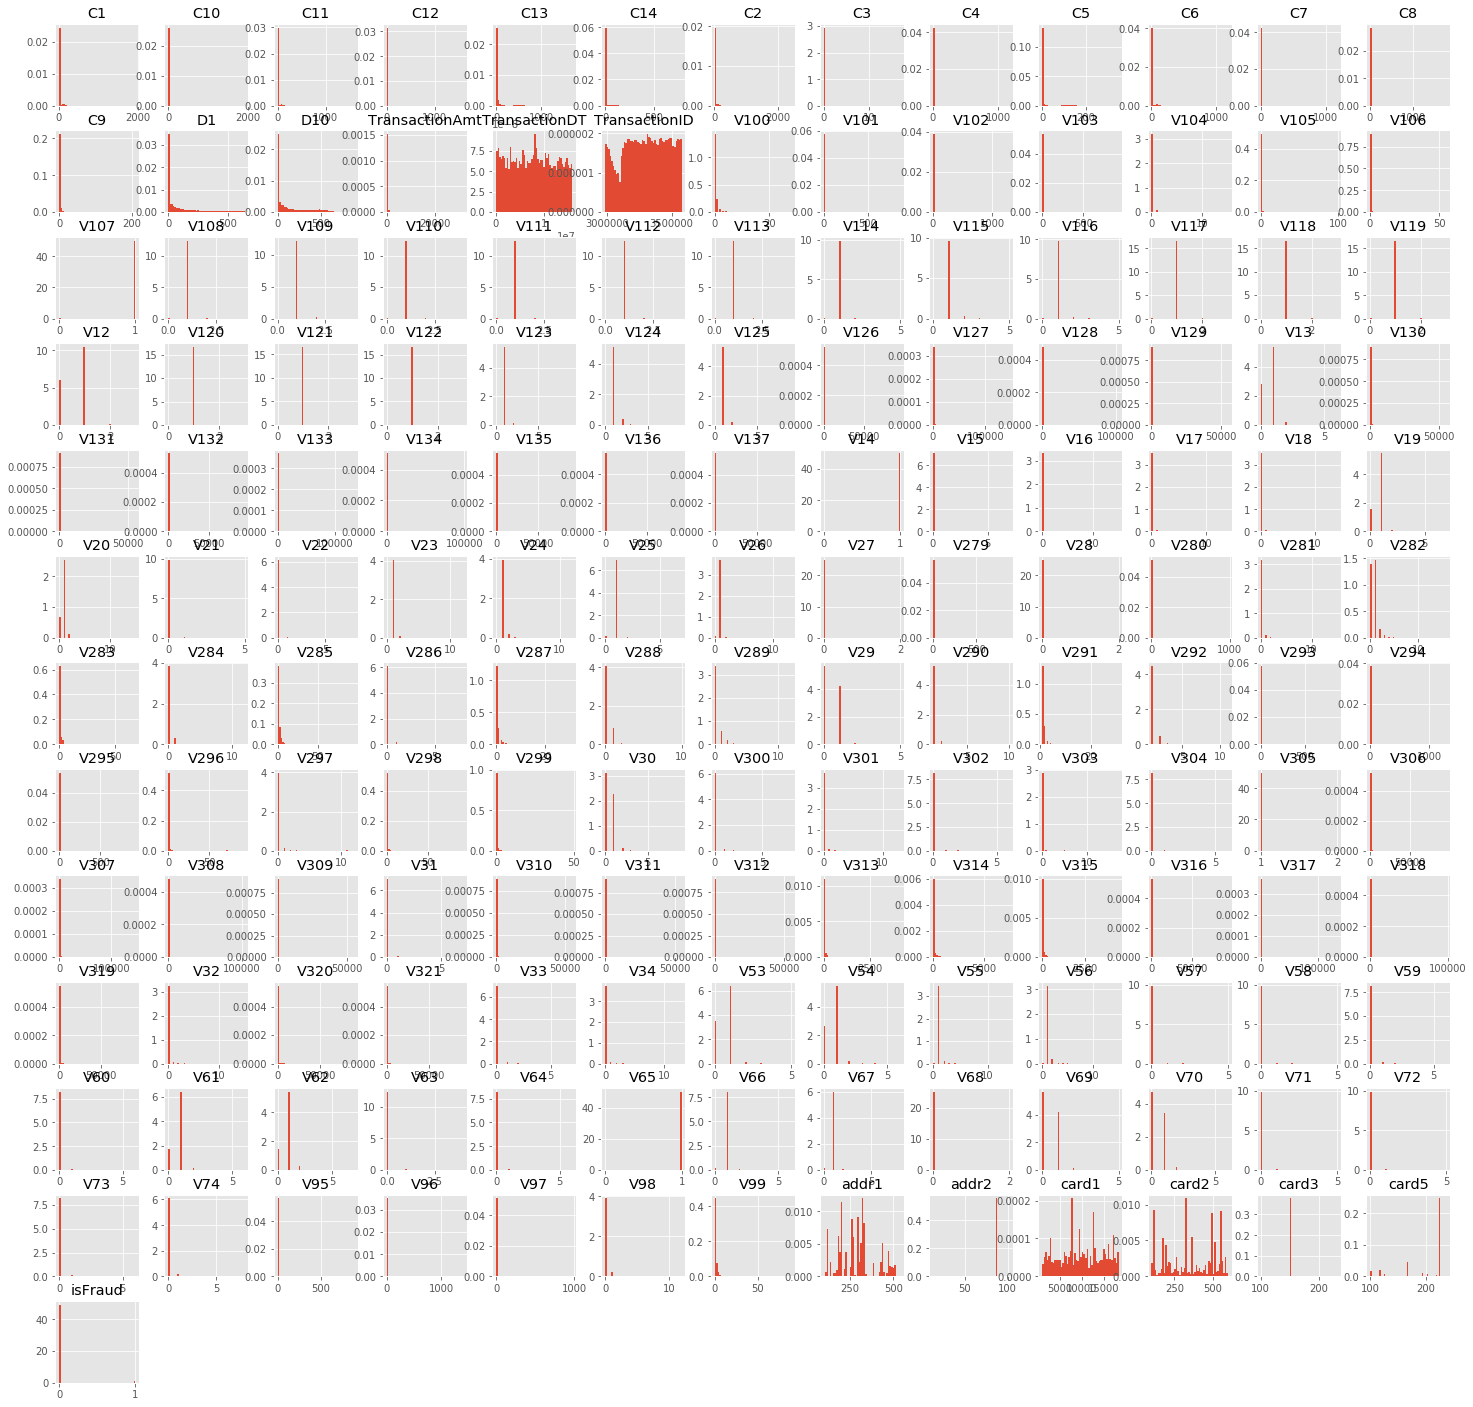

In [ ]:
list(data_cca.columns)

##  Looking at the Categorical Data

In [ ]:
#Categorical data
#Show categorical variables
data_cca[data_cca.select_dtypes(include=['object']).columns]

## Training and testing our data

In [ ]:
from sklearn import preprocessing
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler



In [ ]:

card6_Dummy=pd.get_dummies(data_cca["card6"])
card4_Dummy=pd.get_dummies(data_cca["card4"])
data_cca.shape

data_cca_FULL=pd.concat([data_cca,card6_Dummy],axis=1)
data_cca_FULL=pd.concat([data_cca_FULL,card4_Dummy],axis=1)

#Drop the categorical data as it has been added with dummy varaibles
data_cca_FULL.drop(columns =["card6", "card4"])
data_cca_FULL.drop(["card4"], axis=1)

#encode categorical data
# Label Encoding for categorical variables.
for f in data_cca_FULL.columns:
    if data_cca_FULL[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(data_cca_FULL[f].values))
        data_cca_FULL[f] = lbl.transform(list(data_cca_FULL[f].values))

In [ ]:
#See how much fruad is in the data set
print(len(data_cca_FULL[data_cca_FULL["isFraud"]==1])/len(data_cca_FULL)*100)

This is a concern as we have dropped some our fraudlent data values.
From this result we can see there is a huge imbalance of our data and to prevent over fitting we are going to use some under sampling techinques.

As we don't want to over fit the training we are going to undersample our training data form dataset.

In [ ]:

#split for training
x_full_df=data_cca_FULL.drop(["isFraud"],axis=1)
y_full_df=data_cca_FULL["isFraud"]

# Now that we have separated the target variable
# Time to undersample 
rus = RandomUnderSampler()
x_full_df, y_full_df = rus.fit_resample(x_full_df, y_full_df)

# Check
print(x_full_df.shape, y_full_df.shape)

In [ ]:

# Check Dataset Balance 
print(f'Total number of Transactions {x_full_df.shape[0]}')
print(f'Total Number of Fraudulent Transactions {y_full_df.sum()}')
print(f'Exactly {(y_full_df.sum()/x_full_df.shape[0])*100:0.3f}% of the transactions are Fraudulent')


Making our own training and test sets from this data for our Model. Using this we will determine how accurate our model is:

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(x_full_df,y_full_df,test_size=0.50)

#how model
lr = LogisticRegression(solver='lbfgs')  
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

In [ ]:
y_pred=lr.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
recall_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
recall_score(y_test, y_pred)

Our recall is 41.8% which is higher than prevoius result if we did not do the under sampling

We can improve this model by checking the correlation between each feature and take out a features that are not that relivant